In [1]:
import pandas as pd
import numpy as np
import math

# Finance
import mplfinance as mpf
import ta
import yfinance as yf

import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from torch.optim import Adam

import matplotlib.pyplot as plt



# System
from dotenv import load_dotenv
import os
from pathlib import Path
import requests
import sys
import time

sys.path.append('../') # Change the python path at runtime
from src.utils import path as path_yq


In [2]:
load_dotenv()
cur_dir = Path.cwd()

POLYGON_API_KEY = os.environ.get("POLYGON_API_KEY")

# Fetch Tick Data
- Add feature to pull from data instead of fetching

## Polygon API

In [4]:
# TODO: Scale this up to n years
ticker = "NVDA"
max_limit = 50000
start_date = "2000-01-01"
end_date = "2024-12-31"

api_url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit={max_limit}&apiKey={POLYGON_API_KEY}"



In [ ]:
str = "N" # Reset
str = input("Confirm?")

if str == "Y":
    resp = requests.get(api_url)
    print(f"Request made.")

In [ ]:
resp

In [ ]:
cols = ["Date", "Open", "High", "Low", "Close", "Volume", "VWAP", "Transactions"]
if resp.status_code == 200:
    dict_list = resp.json().get('results')
    df = pd.DataFrame(dict_list)

    column_map = {
        't': 'Timestamp',
        'o': 'Open',
        'h': 'High',
        'l': 'Low',
        'c': 'Close', 
        'n': 'Transactions', # Number of trades (market activity)
        'v': 'Volume', # Number of shares traded (intensity of the activity)
        'vw': 'VWAP'
    }

    df.rename(columns=column_map, inplace=True)

    df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='ms')
    df['Date'] = df['Datetime'].dt.normalize() # Remove the time and return date object

    df = df[cols]
    df.set_index(keys="Date", inplace=True)
else:
    print(f"Error fetching data: {resp.status_code}, {resp.text}")

In [ ]:
df

## Yfinance

In [ ]:
import seaborn as sns
historical_start_date = '2022-08-09'
# Define the ticker list
# Capitaland A17U, SUNT.SI cannot download
ticker_list = ['S51.SI']

# Fetch the data
data = yf.download(ticker_list, historical_start_date)['Adj Close'] # Auto adjust is false
data.index = pd.to_datetime(data.index)
display(data.tail(20))
data.plot()

plt.figure(figsize=(3,2))
sns.heatmap(data.corr(), cmap="Reds", annot=True)
plt.show()

In [ ]:
df


## Read Data

In [5]:
root_dir = path_yq.get_root_dir(cur_dir=cur_dir)
csv_path = Path.joinpath(root_dir, "data", f"{ticker}_{start_date}_{end_date}.csv")

# Get df
try:
    df.to_csv(csv_path)
except NameError:
    print(f"df not defined, trying to fetch from csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        # Convert data
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index(keys="Date", inplace=True)

df not defined, trying to fetch from csv


In [6]:
df.tail(6)

,Open,High,Low,Close,Volume,VWAP,Transactions
Date,,,,,,,
2024-03-27,931.12,932.4000,891.23,902.50,58604623.0,903.2442,1189234
2024-03-28,900.00,913.0000,891.93,903.56,43521227.0,905.0035,771056
2024-04-01,902.99,922.2500,892.04,903.63,45194149.0,905.1506,872234
2024-04-02,884.48,900.9400,876.20,894.52,43254505.0,889.6058,838078
2024-04-03,884.84,903.7400,884.00,889.64,36940205.0,895.4629,698935
2024-04-04,904.06,906.3399,858.80,859.05,43471542.0,883.5065,892804


mpf plot: https://github.com/matplotlib/mplfinance?tab=readme-ov-file

In [ ]:
mpf.plot(df, type='candle', style='charles', figsize=(20, 10), title="OHLC Bars for NVDA", volume=True, show_nontrading=True, mav=(3, 6, 9))

In [ ]:
df.isna().sum()


# Features
- Technical indicators
- Fundamental indicators
- Date features
- Holiday indicators etc.

# Preprocessing
- Train-test split
- Scale data (only fit-transform for train, but not for test)
- Decide which to predict. Have open and predict the close for the same day? Have the close for the previous day and predict next open?

In [7]:
def create_technical_indicators(tmp: pd.DataFrame):
    df = tmp.copy(deep=True)

    # Date features
    df['Year'], df['Month'], df['Day'] = df.index.year, df.index.month, df.index.day

    # Use the close price to create the indicators
    df['BB High'], df['BB Low']= ta.volatility.bollinger_hband(df['Close']), ta.volatility.bollinger_lband(df['Close'])

    
    
    # Takes the past 20 data, including the current one to calculate the mean
    df['MA_50'] = df['Close'].rolling(window=50).mean()

    df['MA_20'] = df['Close'].rolling(window=20).mean()

    df['MA_5'] = df['Close'].rolling(window=5).mean()

    df['Future Close'] = df['Close'].shift(-1)

    return df

In [8]:
df2 = create_technical_indicators(tmp=df)

In [9]:
df2

,Open,High,Low,Close,Volume,VWAP,Transactions,Year,Month,Day,BB High,BB Low,MA_50,MA_20,MA_5,Future Close
Date,,,,,,,,,,,,,,,,
2022-04-06,249.34,253.0000,240.0300,244.07,70076148.0,245.2649,988183,2022,4,6,NaN,NaN,NaN,NaN,NaN,242.08
2022-04-07,244.41,247.2200,234.7800,242.08,55799236.0,241.5490,714654,2022,4,7,NaN,NaN,NaN,NaN,NaN,231.19
2022-04-08,239.17,239.2300,230.6201,231.19,52478064.0,233.2497,671401,2022,4,8,NaN,NaN,NaN,NaN,NaN,219.17
2022-04-11,222.14,223.1994,216.6000,219.17,57483434.0,219.5560,883230,2022,4,11,NaN,NaN,NaN,NaN,NaN,215.04
2022-04-12,225.37,227.2500,212.8204,215.04,65771807.0,218.7215,926864,2022,4,12,NaN,NaN,NaN,NaN,230.310,222.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-28,900.00,913.0000,891.9300,903.56,43521227.0,905.0035,771056,2024,3,28,956.654449,832.196051,769.3521,894.42525,924.916,903.63
2024-04-01,902.99,922.2500,892.0400,903.63,45194149.0,905.1506,872234,2024,4,1,951.360972,845.573528,776.0033,898.46725,917.064,894.52
2024-04-02,884.48,900.9400,876.2000,894.52,43254505.0,889.6058,838078,2024,4,2,949.135068,852.014432,781.9955,900.57475,905.964,889.64


In [10]:
df2.dropna(inplace=True)
# Removes the row that doesn't have a target also
df2

,Open,High,Low,Close,Volume,VWAP,Transactions,Year,Month,Day,BB High,BB Low,MA_50,MA_20,MA_5,Future Close
Date,,,,,,,,,,,,,,,,
2022-06-16,158.600,159.4232,154.01,156.01,54484867.0,155.9775,568658,2022,6,16,199.608940,151.195060,188.8876,175.40200,161.170,158.80
2022-06-17,156.480,159.9500,153.28,158.80,63033397.0,157.8160,496529,2022,6,17,200.000810,149.559190,187.1822,174.78000,158.982,165.66
2022-06-21,164.745,170.0800,164.07,165.66,48307138.0,167.5516,518114,2022,6,21,200.022415,149.409585,185.6538,174.71600,160.820,163.60
2022-06-22,162.260,166.6200,161.80,163.60,43799744.0,164.4195,436479,2022,6,22,200.103538,148.790462,184.3020,174.44700,161.868,162.25
2022-06-23,165.185,165.8500,158.53,162.25,46367959.0,161.5169,489644,2022,6,23,200.069374,148.895626,183.1636,174.48250,161.264,171.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,931.120,932.4000,891.23,902.50,58604623.0,903.2442,1189234,2024,3,27,965.378389,812.228111,762.4915,888.80325,927.074,903.56
2024-03-28,900.000,913.0000,891.93,903.56,43521227.0,905.0035,771056,2024,3,28,956.654449,832.196051,769.3521,894.42525,924.916,903.63
2024-04-01,902.990,922.2500,892.04,903.63,45194149.0,905.1506,872234,2024,4,1,951.360972,845.573528,776.0033,898.46725,917.064,894.52


## Scale, Load Dataset

In [ ]:
start_time = time.time()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time is {elapsed_time:3f}s.")

In [11]:
def scale(X_train, X_val, type='standard'):
    """
    Scale based on the train and val/test data with a specific type.
    """
    type = 'standard'
    if type == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    return X_train_scaled, X_val_scaled

In [12]:


def convert_numpy_torch(arr: np.ndarray) -> torch:
    if isinstance(arr, (pd.DataFrame, pd.Series)):
        arr = arr.to_numpy()
    if isinstance(arr, np.ndarray):
        # This does not make a copy, but any changes will affect the original arr
        # Alternative: torch.tensor(arr, dtype=torch.float32)
        return torch.from_numpy(arr).float().to(device) # Ensure it is a float tensor, and move to device
    else:
        raise ValueError(f"The input\n{arr}\nis not an ndarray, it is a {type(arr)}.")

def load_data(X, y, batch_size, shuffle):
    dataset = TensorDataset(convert_numpy_torch(X),
                                convert_numpy_torch(y))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


# Model Class

In [37]:
class EarlyStopper:
    def __init__(self, patience=5):
        self.min_loss = np.inf
        self.patience = patience
        self.counter = 0
        self.delta = 0.1 # TODO: Might wanna adjust based on stock volatility

    def stop(self, loss: float) -> bool:
        if loss < self.min_loss - self.delta:
            self.min_loss = loss
            # Reset counter
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



LSTM self-define ReLU: https://discuss.pytorch.org/t/change-tanh-activation-in-lstm-to-relu/14160

In [53]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size=None, num_layers=None, **kwargs):
        super().__init__() # Need bracket for super
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = 1
        self.bidir = False # Hardcoded since bidir won't be used for stock price pred

        self.rnn = nn.RNN(
            input_size=input_size, 
            hidden_size=self.hidden_size, 
            num_layers=self.num_layers, # Dropout has no effect on single hidden layer
            nonlinearity='tanh', # or relu
            bias=True,
            batch_first=False,
            dropout=0.2,
            bidirectional=self.bidir, # Can be True for NLP, but will introduce lookahead bias for stock
        )

        total_features = self.hidden_size * 2 if self.bidir else self.hidden_size
        # Use linear layer for fully connected layer to map to 1 column of output
        self.fc = nn.Linear(
            in_features=total_features,
            out_features=self.output_size
            )
    
    # Must override the parent class's forward method
    def forward(self, x):
        rnn_out, _ = self.rnn(x)

        # print(rnn_out.shape) # [batch_size, features]

        return self.fc(rnn_out)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=None, num_layers=None, **kwargs):
        super().__init__() # Need bracket for super
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = 1
        self.bidir = False # Hardcoded since bidir won't be used for stock price pred

        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=self.hidden_size, 
            num_layers=self.num_layers, # Dropout has no effect on single hidden layer
            bias=True,
            batch_first=False,
            dropout=0.2,
            bidirectional=self.bidir, # Can be True for NLP, but will introduce lookahead bias for stock
        )

        total_features = self.hidden_size * 2 if self.bidir else self.hidden_size
        # Use linear layer for fully connected layer to map to 1 column of output
        self.fc = nn.Linear(
            in_features=total_features,
            out_features=self.output_size
            )
    
    # Must override the parent class's forward method
    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        # print(rnn_out.shape) # [batch_size, features]
        return self.fc(lstm_out)
        

In [54]:
from collections import defaultdict
class custom_model():
    def __init__(self, type='RNN', lr=None, n_epoch=None, device=None, **kwargs):
        self.lr = lr
        self.n_epoch = n_epoch
        self.input_size = kwargs.get('input_size', None)
        self.hidden_size = kwargs.get('hidden_size', 1)
        self.num_layers = kwargs.get('num_layers', 1)
        self.train_dataloader = kwargs.get('train_dataloader', None)
        self.val_dataloader = kwargs.get('val_dataloader', None)
        
        if type == 'RNN':
            self.model = RNN(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers
            ).to(device)
        elif type == 'LSTM':
            self.model = LSTM(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers
            ).to(device)
        self.optimiser = Adam(params=self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss() # Use sqrt for RMSE
        self.model_dict = defaultdict(list)
        self.early_stopper = EarlyStopper()

    def fit(self):
        for epoch in range(self.n_epoch):
            total_train_loss = 0
            total_val_loss = 0
            total_train_samples = 0
            total_val_samples = 0
            
            start_time = time.time()
            
            self.model.train()
            for input, target in self.train_dataloader:
                self.optimiser.zero_grad() # Resets gradient of the optimised Tensors to None
                output = self.model(input)
                # print(output.shape, target.shape)
                assert output.squeeze(-1).shape == target.shape
                # Using RMSE for both train and eval
                loss = self.loss_fn(output, target)
                # print(input.shape[0])
                total_train_loss += loss.item() * input.shape[0] # Tensor operation: get the scalar in a tensor with 1 element
                total_train_samples += input.shape[0]

                loss.backward() # Compute the gradient of the loss wrt weights, backpropagate
                self.optimiser.step() # Takes a step in the direction that reduces the loss, updates params
            
            self.model.eval() # Disable dropout
            with torch.no_grad():
                for input, target in self.val_dataloader:
                    output = self.model(input)
                    loss = self.loss_fn(output, target)
                    total_val_loss += loss.item() * input.shape[0]
                    total_val_samples += input.shape[0]
            
            # Calculating and logging metadata
            # Add train, val loss to dict for each epoch
            avg_train_loss = math.sqrt(total_train_loss / total_train_samples) # Take the mean of MSE for all batches 
            avg_val_loss = math.sqrt(total_val_loss / total_val_samples)

            self.model_dict['train_loss'].append(avg_train_loss)
            self.model_dict['val_loss'].append(avg_val_loss)
            
            end_time = time.time()
            elapsed_time = end_time - start_time
            self.model_dict['time'].append(elapsed_time)
            # print(f"Elapsed time is {elapsed_time:3f}s.")

            if self.early_stopper.stop(loss=avg_val_loss) == True:
                print(f"Early stopping at epoch {epoch + 1}.")
                break

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1} has completed.")

        # After the whole training is completed, we can plot the losses, time and analyse which model is the best 
        # Train with full set and save the model for testing
    
    def plot_loss(self):
        model_df = pd.DataFrame(self.model_dict)
        plt.figure(figsize=(5, 3))
        plt.plot(np.arange(1, len(model_df) + 1), model_df[['train_loss']], label='Train Loss')
        plt.plot(np.arange(1, len(model_df) + 1), model_df[['val_loss']], label='Validation Loss')
        final_train_loss = model_df[['train_loss']].iloc[-1].item()
        final_val_loss = model_df[['val_loss']].iloc[-1].item()
        plt.axhline(final_train_loss, color='g', linestyle='--', label=f"{final_train_loss:.2f}")
        plt.axhline(final_val_loss, color='r', linestyle='--', label=f"{final_val_loss:.2f}")
        plt.title(f"Train vs Validation Loss")
        plt.xlabel(f"Epoch")
        plt.ylabel(f"RMSE Loss")
        plt.legend()
        plt.show()
        

## Fitting

# Split data

- Need to have train, val, test
- General requirements:
    - Ideally no NA values, otherwise model performance might be affected
    - Number of rows TBC, cannot be too little (not enough data to train), and cannot 
    be too much also (computationally expensive)
- Specific requirements:
    - df2 (not sure if need date as index yet)
    - Features (should be able to have both categorical and numerical)
    - Target variable: Future Close

In [40]:
# We still need the current Close to predict the next close
X = df2.drop(columns=['Future Close'])
y = df2['Future Close']

In [ ]:
# iterdata = iter(train_dataloader)
# input, label = next(iterdata)
# input.shape
# print(len(train_dataloader), input.shape)
# # This is len_seq, batch_size, n_features

Using different training size to perform time series split/expanding window can
help understand how the model performs with different subsets of data.

If the model performs worse with a larger set of data, the smaller dataset might
not be able to generalise the overall trend, which indicates a potential shift
in market trends. Additionally, the features are not likely to have a high predictive
power on the target.

Length train + val, test: 360, 91
Length train, val: 80, 90.


/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likel

Epoch 10 has completed.
Epoch 20 has completed.
Epoch 30 has completed.
Epoch 40 has completed.
Epoch 50 has completed.
Epoch 60 has completed.
Epoch 70 has completed.
Epoch 80 has completed.
Epoch 90 has completed.
Epoch 100 has completed.


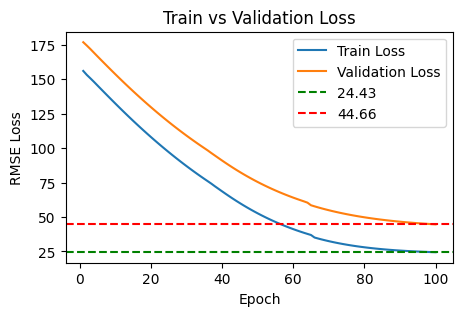

Length train, val: 170, 90.


/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likel

Epoch 10 has completed.
Epoch 20 has completed.
Epoch 30 has completed.
Epoch 40 has completed.
Epoch 50 has completed.
Epoch 60 has completed.
Epoch 70 has completed.
Early stopping at epoch 73.


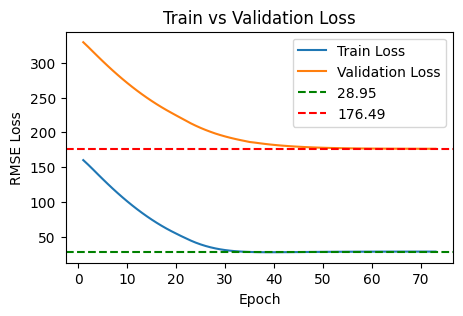

Length train, val: 260, 90.


/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely 

Epoch 10 has completed.
Epoch 20 has completed.
Epoch 30 has completed.
Epoch 40 has completed.
Epoch 50 has completed.
Epoch 60 has completed.
Epoch 70 has completed.
Epoch 80 has completed.
Epoch 90 has completed.
Epoch 100 has completed.


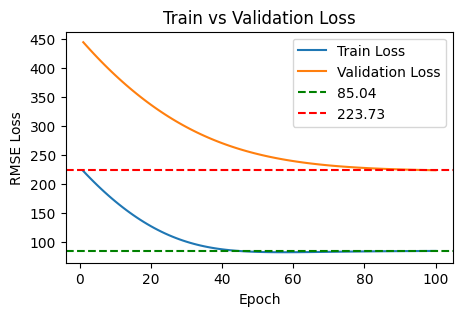

In [55]:
device = torch.device('mps') # torch.device('cpu')
n_splits = 3
split_idx = int(len(df2) * 0.8)
scaler_type = 'minmax' # Standard scaler does not provide good results
batch_size = 32 # Larger batch size takes longer to converge, tried 64 and 32
shuffle = False

# FIXME: Assess the model on different sets and use the best one
# TODO: Gap
tscv = TimeSeriesSplit(n_splits=n_splits, gap=10)

# TODO: Assess the models
# Now do CV for assessing robustness, but later on, the train and validation should
# Choose the best model/just go according to the sequential split
print(f"Length train + val, test: {split_idx}, {len(df2) - split_idx}")
for train_idx, val_idx in tscv.split(X.iloc[:split_idx]):
    print(f"Length train, val: {len(train_idx)}, {len(val_idx)}.")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    X_train_scaled, X_val_scaled = scale(X_train=X_train, X_val=X_val, type=scaler_type)
    
    train_dataloader = load_data(X=X_train_scaled, y=y_train, batch_size=batch_size, shuffle=shuffle)
    val_dataloader = load_data(X=X_val_scaled, y=y_val, batch_size=batch_size, shuffle=shuffle)

    kwargs = {
        'input_size': X.shape[-1],
        'hidden_size': 32 , # 64 and 128 have weird spikes at the end
        'num_layers': 4,
        'train_dataloader': train_dataloader,
        'val_dataloader': val_dataloader
        
    }
    # lr 0.1 is too high, will fluctuate at the end
    # rnn = custom_model(type='RNN', lr=0.05, n_epoch=100, device=device, **kwargs) # It's wrong to write kwargs=kwargs
    # rnn.fit()
    # rnn.plot_loss()

    lstm = custom_model(type='LSTM', lr=0.05, n_epoch=100, device=device, **kwargs) # It's wrong to write kwargs=kwargs
    lstm.fit()
    lstm.plot_loss()
X_test, y_test = X.iloc[split_idx:], y.iloc[split_idx:]



## Prediction

In [ ]:
# TODO: Add analysis to the lost_dict and time

Afterwards for really testing against test

In [ ]:
#
# X_train, X_val, y_train, y_val = train_test_split(X.iloc[:split_idx], y.iloc[:split_idx], shuffle=False, test_size=0.2)